## Estimating Homography matrix

In [1]:
import geopandas as gpd
import pandas as pd

#from fiona.drvsupport import supported_drivers

#gpd.io.file.fiona.drvsupport.supported_drivers["LIBKML"] = "rw"


#supported_drivers['LIBKML'] = 'rw'

#gpd.io.file.fiona.drvsupport.supported_drivers['kml'] = 'rw'
#gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'


In [2]:
import fiona
print(f"Fiona supported drivers {fiona.supported_drivers}\n")

print(f"Add KML to Fiona supported drivers...\n")
fiona.drvsupport.supported_drivers['KML'] = 'rw'

print(f"Fiona supported drivers {fiona.supported_drivers}")

Fiona supported drivers {'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r'}

Add KML to Fiona supported drivers...

Fiona supported drivers {'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r', 'KML': 'rw'}


In [3]:
files = [
    'street_rectangle.kml',
    'parche.kml',
    'tree.kml'
]
target_points = {}
for f in files:
    kpoints = gpd.read_file(f)
    coords = list(kpoints["geometry"][0].exterior.coords)
    coords = [c[:2] for c in coords]
    target_points [f.split('.')[0]] = coords

tree = target_points ['tree'][2:4]
target_points.popitem()
target = [target_points[k][i] for i in range(4) for k in target_points.keys()] + tree
#target =  target_points['tree'][2:4] + target_points['parche'] + target_points['street_rectangle']
target
#target_points

[(-103.4277579789723, 20.63654557516515),
 (-103.4277575318885, 20.63653234065061),
 (-103.4277495976675, 20.6365508448116),
 (-103.4277505019519, 20.63653650674235),
 (-103.4277645711312, 20.63657410193639),
 (-103.4277554179388, 20.63654389661254),
 (-103.4277727565876, 20.6365701138996),
 (-103.427762158771, 20.63653953561339),
 (-103.4278021213562, 20.63647239625929),
 (-103.4278175876926, 20.63646121024951)]

In [4]:
df = pd.DataFrame({'x': [t[0] for t in target], 'y': [t[1] for t in target]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")
gdf.explore()

In [5]:
source_points = {
    'street_rectangle':[(746,641), (816,664), (952,566), (896,558)],
    #'tree_square': [(107, 580), (97,602),(161,593),(166,570)],
    'parche': [(605.5, 674.1), (650.3, 696.1), (729.3, 656), (684.3, 637.5)],
    'tree': [(107.5, 580.6), (95.3, 608.6), (279.6, 580.4), (274.1, 558.4)]
}
tree = source_points ['tree'][2:4]
source_points.popitem()
source = [source_points[k][i] for i in range(4) for k in source_points.keys()] + tree
#source =  source_points['tree'][2:4] + source_points['parche'] + source_points['street_rectangle']
source

[(746, 641),
 (605.5, 674.1),
 (816, 664),
 (650.3, 696.1),
 (952, 566),
 (729.3, 656),
 (896, 558),
 (684.3, 637.5),
 (279.6, 580.4),
 (274.1, 558.4)]

In [6]:
import numpy as np
import cv2

"""Calculate the homography from source to target using RANSAC."""
source = np.array(source).astype(np.float32).reshape(-1, 1, 2)
target = np.array(target).astype(np.float32).reshape(-1, 1, 2)
h, status = cv2.findHomography(source, target)
h

array([[ 1.33002904e-02,  2.80091231e-01, -1.03427615e+02],
       [-2.65385918e-03, -5.58855697e-02,  2.06366171e+01],
       [-1.28595347e-04, -2.70808743e-03,  1.00000000e+00]])

Measure elapsed time in seconds https://stackoverflow.com/questions/7370801/how-do-i-measure-elapsed-time-in-python


In [7]:
from ultralytics import YOLO, checks, hub
import cv2

import time
start = time.time()

model = YOLO('yolov9c.pt')
video = cv2.VideoCapture('ITDP_videos/Video1.mp4')

frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT) / 20)
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
entities = {}

video_analysis = {
    'names': [],
    'boxes': [],
    'pos_msec': [], 
}

for i_frame in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = video.read()
    if not ret:
        continue
    # Track all objects in the frame
    results = model.track(source=frame, persist=True, show=False, verbose=False)
    # Capture relevant data
    video_analysis['names'].append(results[0].names) # do we really need this?
    video_analysis['boxes'].append(results[0].boxes) 
    video_analysis['pos_msec'].append(video.get(cv2.CAP_PROP_POS_MSEC)) # current position in milliseconds

end = time.time()
print(end - start)

433.15709924697876


In [8]:
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
fps = video.get(cv2.CAP_PROP_FPS)

print(f"Number of frames = {frame_count}\nFrames Per Second = {fps}")

Number of frames = 848.0
Frames Per Second = 30.0


- https://docs.opencv.org/4.9.0/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d

- https://stackoverflow.com/questions/47743246/getting-timestamp-of-each-frame-in-a-video

In [9]:
len(video_analysis['pos_msec'])

848

In [14]:

video = cv2.VideoCapture('ITDP_videos/Video1.mp4')

#timestamps = [video.get(cv2.CAP_PROP_POS_MSEC)]
timestamps = []

calc_timestamps = [0.0]

while(video.isOpened()):
    frame_exists, curr_frame = video.read()
    if frame_exists:
        timestamps.append(video.get(cv2.CAP_PROP_POS_MSEC))
        calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
    else:
        break

video.release()

print(len(calc_timestamps))

849


In [27]:
# They're both very similar - equal with a tolerance
for idx, val in enumerate(calc_timestamps[:-1]):
    if abs(video_analysis['pos_msec'][idx]-val) > 0.1:
        print(f"[{idx:04}] diff  {video_analysis['pos_msec'][idx]} != {val}")
        print(f" - tol {abs(video_analysis['pos_msec'][idx]-val)}")

In [43]:
def bbox_to_point(bbox):
  return [(bbox[0, 0] + bbox[1, 0]) / 2, bbox[1, 1]]

coords_px = []
clas = []


for i, id in enumerate(video_analysis['boxes'].id.int().tolist()):
    _class = video_analysis['names'][video_analysis['boxes'].cls[i].int().tolist()]
    print(f"{video_analysis['boxes'].cls[i].int().tolist()} -> {_class}" )
    
    bbox = video_analysis['boxes'].xyxy[i].numpy().astype(float).reshape((2, 2))
    coords_px.append(bbox_to_point(bbox))
    clas.append(_class)

2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car


In [33]:
video_analysis['boxes'][845].id.int().tolist()

[1, 2, 4, 5, 11, 14, 15, 19, 20, 9, 33, 35, 22, 37, 10, 38, 40]

In [44]:
def bbox_to_point(bbox):
  return [(bbox[0, 0] + bbox[1, 0]) / 2, bbox[1, 1]]


video_analysis['coords_px'] = []
video_analysis['clas'] = []

for va_idx in range(len(video_analysis['boxes'])):
    """
    This is iterating over all 848 frames results
    to get all the classes names and coords px of those classes found with the model
    """
    print(f"--- Video {va_idx} ---")
    coords_px = []
    clas = []
    for i, id in enumerate(video_analysis['boxes'][va_idx].id.int().tolist()):
        _class = video_analysis['names'][va_idx][video_analysis['boxes'][va_idx].cls[i].int().tolist()]
        print(f"{video_analysis['boxes'][va_idx].cls[i].int().tolist()} -> {_class}" )
        
        bbox = video_analysis['boxes'][va_idx].xyxy[i].numpy().astype(float).reshape((2, 2))
        coords_px.append(bbox_to_point(bbox))
        clas.append(_class)
    video_analysis['coords_px'].append(coords_px)
    video_analysis['clas'].append(clas)        

--- Video 0 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 1 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 2 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 3 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 4 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 5 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 6 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
0 -> person
0 -> person
2 -> car
--- Video 7 ---
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 -> car
2 

In [56]:
def sample_homography(homography, samples):
  """Get the estimated sample's perspective transform"""
  homography_matrix = np.array(homography).astype(np.float32)
  sample_matrix = np.array(samples).astype(np.float32).reshape(-1, 1, 2)
  estimate_matrix = cv2.perspectiveTransform(sample_matrix, homography_matrix)
  estimate_matrix = estimate_matrix.reshape(-1, 2).tolist()
  return estimate_matrix

## Select a frame 

In [73]:
selected_frame = 847

trajectory = sample_homography(h, video_analysis['coords_px'][selected_frame])
print(f"{trajectory}")

[[-103.42784118652344, 20.63665008544922], [-103.4278564453125, 20.636627197265625], [-103.4278793334961, 20.636417388916016], [-103.42784881591797, 20.636577606201172], [-103.42782592773438, 20.63642692565918], [-103.42789459228516, 20.636707305908203], [-103.4278335571289, 20.63667869567871], [-103.42758178710938, 20.63663101196289], [-103.42791748046875, 20.636686325073242], [-103.42800903320312, 20.636377334594727], [-103.42781066894531, 20.63648223876953], [-103.42800903320312, 20.636783599853516], [-103.42778778076172, 20.636457443237305], [-103.42797088623047, 20.636795043945312], [-103.42781829833984, 20.636432647705078], [-103.42792510986328, 20.636398315429688], [-103.42786407470703, 20.636476516723633]]


In [74]:
import pandas as pd

df = pd.DataFrame({'x': [t[0] for t in trajectory],
                   'y': [t[1] for t in trajectory],
                   'c' : video_analysis['clas'][selected_frame], 
                  })
df

,x,y,c
0,-103.427841,20.636650,car
1,-103.427856,20.636627,car
2,-103.427879,20.636417,car
3,-103.427849,20.636578,car
4,-103.427826,20.636427,person
5,-103.427895,20.636707,car
6,-103.427834,20.636679,car
7,-103.427582,20.636631,traffic light
8,-103.427917,20.636686,car
9,-103.428009,20.636377,car


In [75]:
video_analysis['coords_px'][selected_frame]

[[1085.7913818359375, 425.43023681640625],
 [1000.0141296386719, 424.34375],
 [270.6918258666992, 491.1749267578125],
 [875.789794921875, 447.7783508300781],
 [85.86320114135742, 566.4491577148438],
 [1131.3087158203125, 395.2430419921875],
 [1173.65869140625, 422.53265380859375],
 [175.35562896728516, 121.61719512939453],
 [1055.5789794921875, 392.8259582519531],
 [402.42332458496094, 425.7054748535156],
 [394.58909606933594, 554.8150024414062],
 [1107.0811767578125, 367.6308288574219],
 [34.7617244720459, 662.0217895507812],
 [1156.0929565429688, 370.0487060546875],
 [106.16496658325195, 568.9000244140625],
 [325.6846618652344, 458.722412109375],
 [513.5405731201172, 474.1434020996094]]

In [76]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
)
gdf

,x,y,c,geometry
0,-103.427841,20.636650,car,POINT (-103.42784 20.63665)
1,-103.427856,20.636627,car,POINT (-103.42786 20.63663)
2,-103.427879,20.636417,car,POINT (-103.42788 20.63642)
3,-103.427849,20.636578,car,POINT (-103.42785 20.63658)
4,-103.427826,20.636427,person,POINT (-103.42783 20.63643)
5,-103.427895,20.636707,car,POINT (-103.42789 20.63671)
6,-103.427834,20.636679,car,POINT (-103.42783 20.63668)
7,-103.427582,20.636631,traffic light,POINT (-103.42758 20.63663)
8,-103.427917,20.636686,car,POINT (-103.42792 20.63669)
9,-103.428009,20.636377,car,POINT (-103.42801 20.63638)


Find higher resolution maps
- https://stackoverflow.com/questions/73705036/python-geopandas-world-map-with-higher-resolution
- https://gis.stackexchange.com/questions/182944/seeking-polygon-shapefile-of-countries-states-and-islands

In [77]:
import folium
gdf.explore(column='c', cmap=['red', 'blue', 'green', 'yellow'], zoom_start=100, legend=True, k=2)

## Distance between two objects

In [78]:
ref = gdf['geometry'][0]
gdf["distance"] = gdf["geometry"].distance(ref)
gdf

/tmp/ipykernel_211801/2974551813.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance"] = gdf["geometry"].distance(ref)


,x,y,c,geometry,distance
0,-103.427841,20.636650,car,POINT (-103.42784 20.63665),0.000000
1,-103.427856,20.636627,car,POINT (-103.42786 20.63663),0.000028
2,-103.427879,20.636417,car,POINT (-103.42788 20.63642),0.000236
3,-103.427849,20.636578,car,POINT (-103.42785 20.63658),0.000073
4,-103.427826,20.636427,person,POINT (-103.42783 20.63643),0.000224
5,-103.427895,20.636707,car,POINT (-103.42789 20.63671),0.000078
6,-103.427834,20.636679,car,POINT (-103.42783 20.63668),0.000030
7,-103.427582,20.636631,traffic light,POINT (-103.42758 20.63663),0.000260
8,-103.427917,20.636686,car,POINT (-103.42792 20.63669),0.000084
9,-103.428009,20.636377,car,POINT (-103.42801 20.63638),0.000320


### EPSG:3310
- https://gis.stackexchange.com/questions/293310/finding-distance-between-two-points-with-geoseries-distance
- https://spatialreference.org/ref/epsg/3310/


In [79]:
gdf.to_crs(epsg=3310, inplace=True)
ref = gdf['geometry'][9]
gdf["distance"] = gdf["geometry"].distance(ref)
gdf

,x,y,c,geometry,distance
0,-103.427841,20.636650,car,POINT (1777303.367 -1751402.208),34.347263
1,-103.427856,20.636627,car,POINT (1777302.173 -1751404.907),31.398511
2,-103.427879,20.636417,car,POINT (1777303.649 -1751427.452),14.623577
3,-103.427849,20.636578,car,POINT (1777303.907 -1751409.991),27.528696
4,-103.427826,20.636427,person,POINT (1777309.141 -1751425.445),20.439142
5,-103.427895,20.636707,car,POINT (1777296.633 -1751397.178),37.412772
6,-103.427834,20.636679,car,POINT (1777303.644 -1751399.049),37.394785
7,-103.427582,20.636631,traffic light,POINT (1777331.258 -1751399.356),53.463816
8,-103.427917,20.636686,car,POINT (1777294.594 -1751399.818),34.515624
9,-103.428009,20.636377,car,POINT (1777290.627 -1751434.105),0.000000


### EPSG:32663
- Other option for georeference 
- https://spatialreference.org/ref/epsg/32663/

In [80]:
#gdf.to_crs(epsg=32662, inplace=True)
#ref = gdf['geometry'][9]
#gdf["distance"] = gdf["geometry"].distance(ref)
#gdf

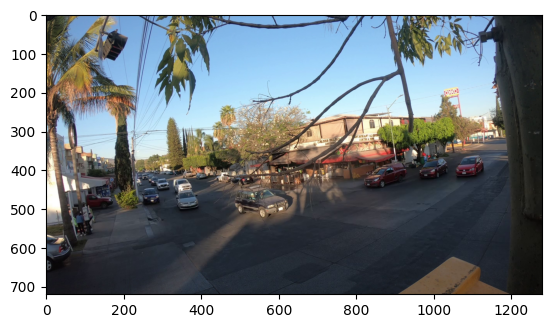

In [81]:
import matplotlib.pyplot as plt
import cv2

# function to display the coordinates of 
# of the points clicked on the image  
def click_event(event, x, y, flags, params): 
  
    # checking for left mouse clicks 
    if event == cv2.EVENT_LBUTTONDOWN: 
  
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
  
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font, 
                    1, (255, 0, 0), 2) 
        cv2.imshow('image', img) 
  
    # checking for right mouse clicks      
    if event==cv2.EVENT_RBUTTONDOWN: 
  
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
  
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        b = img[y, x, 0] 
        g = img[y, x, 1] 
        r = img[y, x, 2] 
        cv2.putText(img, str(b) + ',' +
                    str(g) + ',' + str(r), 
                    (x,y), font, 1, 
                    (255, 255, 0), 2) 
        cv2.imshow('image', img) 

f = cv2.VideoCapture('ITDP_videos/Video1.mp4')
_,img = f.read()
# displaying the image 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
#cv2.imshow('image', img) 

# setting mouse handler for the image 
# and calling the click_event() function 
#cv2.setMouseCallback('image', click_event) 

# wait for a key to be pressed to exit 
#cv2.waitKey(0) 

# close the window 
#cv2.destroyAllWindows() 

  
